# MLP update

Start with MLP 08.
Update the code to use our more recent python functions.

Use Kmer frequencies, K=3, i.e. bag of words.
For campatibility with RNN, prepare uniform length arrays.
Use code designed for data slices based on max len.
This code builds a dataframe of uniform dimensions so all seqs must have uniform length.
This code appends Kmers like 'NNN' to achieve uniform length.
As such, this code is very slow on the full dataet.

This code builds model and runs cross validation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import LayerNormalization

dt='float32'
tf.keras.backend.set_floatx(dt)

EPOCHS=100
SPLITS=1
K=3
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=16

## Load and partition sequences

In [2]:
# Assume file was preprocessed to contain one line per seq.
# Prefer Pandas dataframe but df does not support append.
# For conversion to tensor, must avoid python lists.
def load_fasta(filename,label):
    DEFLINE='>'
    labels=[]
    seqs=[]
    lens=[]
    nums=[]
    num=0
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE:
                seq=line.rstrip()
                num += 1   # first seqnum is 1
                seqlen=len(seq)
                nums.append(num)
                labels.append(label)
                seqs.append(seq)
                lens.append(seqlen)
    df1=pd.DataFrame(nums,columns=['seqnum'])
    df2=pd.DataFrame(labels,columns=['class'])
    df3=pd.DataFrame(seqs,columns=['sequence'])
    df4=pd.DataFrame(lens,columns=['seqlen'])
    df=pd.concat((df1,df2,df3,df4),axis=1)
    return df

# Split into train/test stratified by sequence length.
def sizebin(df):
    return pd.cut(df["seqlen"],
                              bins=[0,1000,2000,4000,8000,16000,np.inf],
                              labels=[0,1,2,3,4,5])
def make_train_test(data):
    bin_labels= sizebin(data)
    from sklearn.model_selection import StratifiedShuffleSplit
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=37863)
    # split(x,y) expects that y is the labels. 
    # Trick: Instead of y, give it it the bin labels that we generated.
    for train_index,test_index in splitter.split(data,bin_labels):
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]
    return (train_set,test_set)

def separate_X_and_y(data):
    y=   data[['class']].copy()
    X=   data.drop(columns=['class','seqnum','seqlen'])
    return (X,y)

def make_slice(data_set,min_len,max_len):
    print("original "+str(data_set.shape))
    too_short = data_set[ data_set['seqlen'] < min_len ].index
    no_short=data_set.drop(too_short)
    print("no short "+str(no_short.shape))
    too_long = no_short[ no_short['seqlen'] >= max_len ].index
    no_long_no_short=no_short.drop(too_long)
    print("no long, no short "+str(no_long_no_short.shape))
    return no_long_no_short


## Make K-mers

In [3]:
def make_kmer_table(K):
    npad='N'*K
    shorter_kmers=['']
    for i in range(K):
        longer_kmers=[]
        for mer in shorter_kmers:
            longer_kmers.append(mer+'A')
            longer_kmers.append(mer+'C')
            longer_kmers.append(mer+'G')
            longer_kmers.append(mer+'T')
        shorter_kmers = longer_kmers
    all_kmers = shorter_kmers
    kmer_dict = {}
    kmer_dict[npad]=0
    value=1
    for mer in all_kmers:
        kmer_dict[mer]=value
        value += 1
    return kmer_dict

KMER_TABLE=make_kmer_table(K)

def strings_to_vectors(data,uniform_len):
    all_seqs=[]
    for seq in data['sequence']:
        i=0
        seqlen=len(seq)
        kmers=[]
        while i < seqlen-K+1:
            kmer=seq[i:i+K]
            i += 1
            value=KMER_TABLE[kmer]
            kmers.append(value)
        pad_val=0
        while i < uniform_len:
            kmers.append(pad_val)
            i += 1
        all_seqs.append(kmers)
    pd2d=pd.DataFrame(all_seqs)
    return pd2d   # return 2D dataframe, uniform dimensions

In [4]:
def make_kmers(MAXLEN,train_set):
    (X_train_all,y_train_all)=separate_X_and_y(train_set)

    # The returned values are Pandas dataframes.
    # print(X_train_all.shape,y_train_all.shape)
    # (X_train_all,y_train_all)
    # y: Pandas dataframe to Python list.
    # y_train_all=y_train_all.values.tolist()
    # The sequences lengths are bounded but not uniform.
    X_train_all
    print(type(X_train_all))
    print(X_train_all.shape)
    print(X_train_all.iloc[0])
    print(len(X_train_all.iloc[0]['sequence']))

    # X: List of string to List of uniform-length ordered lists of K-mers.
    X_train_kmers=strings_to_vectors(X_train_all,MAXLEN)
    # X: true 2D array (no more lists)
    X_train_kmers.shape

    print("transform...")
    # From pandas dataframe to numpy to list to numpy
    print(type(X_train_kmers))
    num_seqs=len(X_train_kmers)
    tmp_seqs=[]
    for i in range(num_seqs):
        kmer_sequence=X_train_kmers.iloc[i]
        tmp_seqs.append(kmer_sequence)
    X_train_kmers=np.array(tmp_seqs)
    tmp_seqs=None
    print(type(X_train_kmers))
    print(X_train_kmers)

    labels=y_train_all.to_numpy()
    return (X_train_kmers,labels)

In [5]:
def make_frequencies(Xin):
    # Input:  numpy X(numseq,seqlen)  list of vectors of kmerval where val0=NNN,val1=AAA,etc. 
    # Output: numpy X(numseq,65)    list of frequencies of 0,1,etc.
    Xout=[]
    VOCABULARY_SIZE= 4**K + 1  # plus one for 'NNN'
    for seq in Xin:
        freqs =[0] * VOCABULARY_SIZE
        total = 0
        for kmerval in seq:
            freqs[kmerval] += 1
            total += 1
        for c in range(VOCABULARY_SIZE):
            freqs[c] = freqs[c]/total
        Xout.append(freqs)
    Xnum = np.asarray(Xout)
    return (Xnum)

## Build model

In [6]:
def build_model(maxlen,dimen):
    act="sigmoid"

    embed_layer  = keras.layers.Embedding(
        VOCABULARY_SIZE,EMBED_DIMEN,input_length=maxlen);
    
    dense1_layer = keras.layers.Dense(64, activation=act,dtype=dt,input_dim=VOCABULARY_SIZE)
    dense2_layer = keras.layers.Dense(64, activation=act,dtype=dt)
    dense3_layer = keras.layers.Dense(64, activation=act,dtype=dt)
    output_layer = keras.layers.Dense(1,  activation=act,dtype=dt)

    mlp = keras.models.Sequential()
    #mlp.add(embed_layer)
    mlp.add(dense1_layer)
    mlp.add(dense2_layer)
    mlp.add(dense3_layer)
    mlp.add(output_layer)
    
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    print("...COMPILED")
    return mlp

## Cross validation

In [7]:
def do_cross_validation(X,y,eps,maxlen,dimen):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.2, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]

        print("BUILD MODEL")
        rnn2=build_model(maxlen,dimen)

        print("FIT")
        # this is complaining about string to float
        history=rnn2.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=eps, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )
                        
        fold += 1
        print("Fold %d, %d epochs"%(fold,eps))

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        scores = rnn2.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (rnn2.metrics_names[1], scores[1]*100))
        # What are the other metrics_names?
        # Try this from Geron page 505:
        # np.mean(keras.losses.mean_squared_error(y_valid,y_pred))
        cv_scores.append(scores[1] * 100)
    print()
    print("Validation core mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))


## Load

In [8]:
print("Load data from files.")
nc_seq=load_fasta('ncRNA.fasta',0)
pc_seq=load_fasta('pcRNA.fasta',1)
all_seq=pd.concat((nc_seq,pc_seq),axis=0)

print("Put aside the test portion.")
(train_set,test_set)=make_train_test(all_seq)
# Do this later when using the test data:
# (X_test,y_test)=separate_X_and_y(test_set)

nc_seq=None
pc_seq=None
all_seq=None

print("Ready: train_set")
train_set

Load data from files.
Put aside the test portion.
Ready: train_set


,seqnum,class,sequence,seqlen
1280,1281,0,AGTCCCTCCCCAGCCCAGCAGTCCCTCCAGGCTACATCCAGGAGAC...,348
9088,9089,0,CAGCTCCTGGGATGGCCTCACCTGAGGAGACTCTTGGGCCTTGGCA...,534
6069,6070,1,AGATCTAGGGATGGGGATGGGGAGGAGAAGTGGGAATGGGAAATTG...,592
18549,18550,1,GACGTCTCCCGCGGGCGTCGGCAGGGTCGGCGGCGTCGGCAGCAGT...,945
15027,15028,1,GAGCGCGCGAGCCGGGCCCGGAGCGCACGCCGCCGCCGCCACCGCC...,4382
...,...,...,...,...
3386,3387,0,TTTATGTGGATTGTCTGTCTCATGCTTGTTTCACCAGGGTAGTTAC...,578
6495,6496,0,ATAATGGGAAACTAAGGGCAAGTTCTCATGTTCCTGGTCCTGGCTT...,562
6409,6410,1,GGGTTTATTACTACTGAAGGAAGAACGTGAGTAGGTTAGGATTTCG...,740
7640,7641,1,ACAGCTGTGTTTGGCTGCAGGGCCAAGAGCGCTGTCAAGAAGACCC...,3156


## Len 200-1Kb

Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4224      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 12,609
Trainable params: 12,609
Non-trainable params: 0
_________________________________________________________________
None
Working on full training set, slice by sequence length.
Slice size range [200 - 1000)
original (30290, 4)
no short (30290, 4)
no long, no short (8879, 4)
Sequence to Kmer
<class 'panda

222/222 [==============================] - 0s 2ms/step - loss: 0.4308 - accuracy: 0.8036 - val_loss: 0.5081 - val_accuracy: 0.7708
Epoch 48/100
222/222 [==============================] - 1s 3ms/step - loss: 0.4345 - accuracy: 0.7987 - val_loss: 0.4704 - val_accuracy: 0.7686
Epoch 49/100
222/222 [==============================] - 0s 2ms/step - loss: 0.4366 - accuracy: 0.8006 - val_loss: 0.4466 - val_accuracy: 0.7832
Epoch 50/100
222/222 [==============================] - 0s 2ms/step - loss: 0.4302 - accuracy: 0.8057 - val_loss: 0.4552 - val_accuracy: 0.7815
Epoch 51/100
222/222 [==============================] - 0s 2ms/step - loss: 0.4275 - accuracy: 0.8036 - val_loss: 0.4459 - val_accuracy: 0.7866
Epoch 52/100
222/222 [==============================] - 0s 2ms/step - loss: 0.4274 - accuracy: 0.8036 - val_loss: 0.4455 - val_accuracy: 0.7838
Epoch 53/100
222/222 [==============================] - 1s 2ms/step - loss: 0.4268 - accuracy: 0.8040 - val_loss: 0.4447 - val_accuracy: 0.7866
Epoch

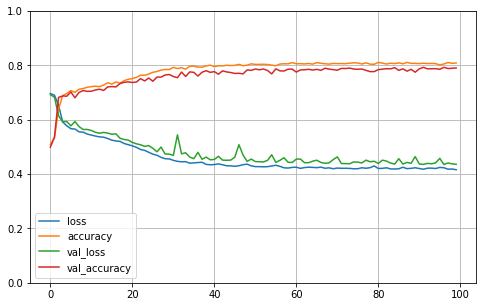

accuracy: 79.05%

Validation core mean 79.05% (+/- 0.00%)


In [9]:
MINLEN=200
MAXLEN=1000

print ("Compile the model")
model=build_model(MAXLEN,EMBED_DIMEN)
print ("Summarize the model")
print(model.summary())  # Print this only once

print("Working on full training set, slice by sequence length.")
print("Slice size range [%d - %d)"%(MINLEN,MAXLEN))
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y

print ("Sequence to Kmer")
(X_train,y_train)=make_kmers(MAXLEN,subset)
X_train
X_train=make_frequencies(X_train)
X_train
print ("Cross valiation")
do_cross_validation(X_train,y_train,EPOCHS,MAXLEN,EMBED_DIMEN)


## Len 1Kb-2Kb

Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                4224      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 12,609
Trainable params: 12,609
Non-trainable params: 0
_________________________________________________________________
None
Working on full training set, slice by sequence length.
Slice size range [1000 - 2000)
original (30290, 4)
no short (9273, 4)
no long, no short (3368, 4)
Sequence to Kmer
<class 'pan

Epoch 48/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5375 - accuracy: 0.7183 - val_loss: 0.5243 - val_accuracy: 0.7270
Epoch 49/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5317 - accuracy: 0.7316 - val_loss: 0.5181 - val_accuracy: 0.7522
Epoch 50/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5299 - accuracy: 0.7298 - val_loss: 0.5147 - val_accuracy: 0.7685
Epoch 51/100
85/85 [==============================] - 0s 3ms/step - loss: 0.5254 - accuracy: 0.7335 - val_loss: 0.5088 - val_accuracy: 0.7641
Epoch 52/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5202 - accuracy: 0.7420 - val_loss: 0.5047 - val_accuracy: 0.7804
Epoch 53/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5174 - accuracy: 0.7442 - val_loss: 0.5069 - val_accuracy: 0.7463
Epoch 54/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5179 - accuracy: 0.7365 - val_loss: 0.5013 - val_accuracy: 0.7774
Epoch 

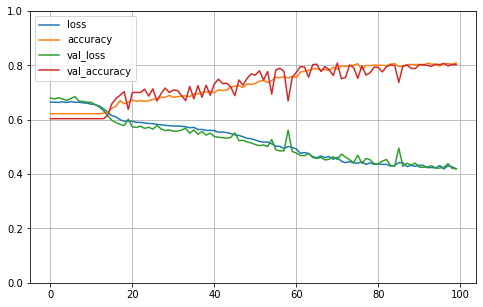

accuracy: 80.27%

Validation core mean 80.27% (+/- 0.00%)


In [10]:
MINLEN=1000
MAXLEN=2000

print ("Compile the model")
model=build_model(MAXLEN,EMBED_DIMEN)
print ("Summarize the model")
print(model.summary())  # Print this only once

print("Working on full training set, slice by sequence length.")
print("Slice size range [%d - %d)"%(MINLEN,MAXLEN))
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y

print ("Sequence to Kmer")
(X_train,y_train)=make_kmers(MAXLEN,subset)
X_train
X_train=make_frequencies(X_train)
X_train
print ("Cross valiation")
do_cross_validation(X_train,y_train,EPOCHS,MAXLEN,EMBED_DIMEN)


## Len 2Kb-3Kb

Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 64)                4224      
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 12,609
Trainable params: 12,609
Non-trainable params: 0
_________________________________________________________________
None
Working on full training set, slice by sequence length.
Slice size range [2000 - 3000)
original (30290, 4)
no short (3221, 4)
no long, no short (1351, 4)
Sequence to Kmer
<class 'pan

Epoch 48/100
34/34 [==============================] - 0s 3ms/step - loss: 0.5591 - accuracy: 0.7167 - val_loss: 0.5637 - val_accuracy: 0.6900
Epoch 49/100
34/34 [==============================] - 0s 3ms/step - loss: 0.5459 - accuracy: 0.7250 - val_loss: 0.5515 - val_accuracy: 0.7085
Epoch 50/100
34/34 [==============================] - 0s 4ms/step - loss: 0.5444 - accuracy: 0.7250 - val_loss: 0.5494 - val_accuracy: 0.7159
Epoch 51/100
34/34 [==============================] - 0s 5ms/step - loss: 0.5451 - accuracy: 0.7194 - val_loss: 0.5501 - val_accuracy: 0.7011
Epoch 52/100
34/34 [==============================] - 0s 6ms/step - loss: 0.5427 - accuracy: 0.7259 - val_loss: 0.5496 - val_accuracy: 0.6937
Epoch 53/100
34/34 [==============================] - 0s 5ms/step - loss: 0.5408 - accuracy: 0.7222 - val_loss: 0.5535 - val_accuracy: 0.7048
Epoch 54/100
34/34 [==============================] - 0s 4ms/step - loss: 0.5406 - accuracy: 0.7250 - val_loss: 0.5456 - val_accuracy: 0.7122
Epoch 

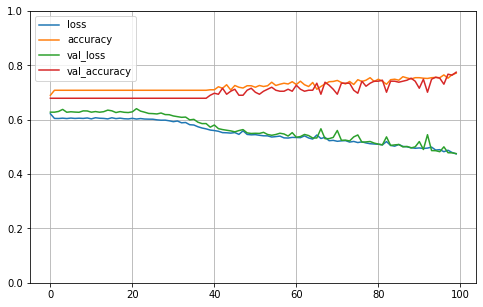

accuracy: 77.49%

Validation core mean 77.49% (+/- 0.00%)


In [11]:
MINLEN=2000
MAXLEN=3000

print ("Compile the model")
model=build_model(MAXLEN,EMBED_DIMEN)
print ("Summarize the model")
print(model.summary())  # Print this only once

print("Working on full training set, slice by sequence length.")
print("Slice size range [%d - %d)"%(MINLEN,MAXLEN))
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y

print ("Sequence to Kmer")
(X_train,y_train)=make_kmers(MAXLEN,subset)
X_train
X_train=make_frequencies(X_train)
X_train
print ("Cross valiation")
do_cross_validation(X_train,y_train,EPOCHS,MAXLEN,EMBED_DIMEN)
